![Xilinx Logo](images/xilinx_logo.png "Xilinx Logo")

# 1. Introduction:

This notebook demonstrates how to captures images from the MIPI devices, then performs face detection or refinedet or SSD inference on it with DPU, and send the video frames with bounding boxes of detected results either to DP to display or stream it out as an RTSP server.

The application is based on the VVAS (Vitis Video Analytics SDK) framework, also utilizing the open source GStreamer plugins.

Vitis Video Analytics SDK (VVAS) is developed by Xilinx to provide many useful GStreamer plugins as the middleware between the application and underlying FPGA acclerators, including DPU AI inference engine, and other PL accelerators such as the one for AI input preprocessing.

Please refer to the [Kria™ KV260 Vision AI Starter Kit Applications GitHub Pages](https://xilinx.github.io/kria-apps-docs/index.html) for detailed HW/SW architecture and [Vitis Video Analytics SDK GitHub Pages](https://xilinx.github.io/VVAS/#) for the VVAS related info.

# 2. Some User Options:

* Option to choose the AI model to run

In [1]:
aitask="yolov3_coco" # "refinedet" 

* Option to set input type

In [2]:
source = "mipi" # choose either 'mipi' or 'usb'

* Option to choose DP / RTSP output

In [3]:
DP_output=True # True to choose DP output, False to choose RTSP output

# 3. Imports and Initialization

## Preapare Data to Visualize the Pipeline

* Create a directory for saving the pipeline graph as dot file. Set the GStreamer debug dot directory environment variable to point to that directory

In [4]:
nb="smartcam"
dotdir = "/tmp/gst-dot/" + nb + "/"
!mkdir -p $dotdir
%env GST_DEBUG_DUMP_DOT_DIR = $dotdir

env: GST_DEBUG_DUMP_DOT_DIR=/tmp/gst-dot/smartcam/


## Import all python modules required for this notebook.

* Import system, util modules

In [5]:
import sys
import glob
import subprocess
import re
import os

* Add some util path

In [6]:
pathv="{}:/usr/sbin:/sbin".format(os.getenv("PATH"))
%env PATH = $pathv

env: PATH=/opt/xilinx/bin:/usr/local/bin:/usr/bin:/bin:/usr/local/sbin:/usr/sbin:/sbin:/usr/local/sbin:/usr/sbin:/sbin:/usr/sbin:/sbin


* GStreamer related library import.

In [7]:
import gi
gi.require_version('Gst', '1.0')
gi.require_version("GstApp", "1.0")
gi.require_version('GstVideo', '1.0')
gi.require_version('GstRtspServer', '1.0')
gi.require_version('GIRepository', '2.0')
from gi.repository import GObject, GLib, Gst, GstVideo, GstRtspServer, GLib, GIRepository

* Initialize.

In [8]:
Gst.init(None)
#Gst.debug_set_threshold_from_string('*:1', True)

[]

# 4. Construct the String Representation of GStreamer Pipeline

## Function ***get_media_by_device*** 

This function returns the matching media node for a given video capture source.

The following sources are supported in this notebook:

* usb : requires USB webcam supporting 1080p output, we recommend the [Logitech BRIO](https://www.logitech.com/en-in/products/webcams/brio-4k-hdr-webcam.960-001105.html).
* mipi : platform1 only

In [9]:
def get_media_dev_by_name(src):
    sources = {
        "usb" : 'uvcvideo',
        'mipi' : 'vcap_csi',
    }
    devices = glob.glob('/dev/media*')
    for dev in devices:
        proc = subprocess.run(['media-ctl', '-d', dev, '-p'], capture_output=True, encoding='utf8')
        for line in proc.stdout.splitlines():
            if sources[src] in line:
                return dev

In [10]:
def get_video_dev_of_mediadev(src):
    proc = subprocess.Popen(['media-ctl', '-d', src, '-p'], stdout=subprocess.PIPE)
    output = subprocess.check_output(('awk', '/^driver\s*uvcvideo/ {u=1} /device node name *\/dev\/video/ {x=$4;f=1;next} u&&f&&/pad0: Sink/ {print x; x=""} f {f=0}'), stdin=proc.stdout).decode('utf8').splitlines()
    if len(output) > 1:
        return output[0]
    

## Get the mediasrc

* Get the mediasrc index by calling get_media_dev_by_name()

In [11]:
media_device = get_media_dev_by_name(source) 
if media_device is None:
    raise Exception('Unable to find video source ' + source + '. Make sure the device is plugged in, powered, and the correct platform is used.')

* mediasrcbin is the Xilinx developed plugin for media devices.

In [12]:
if source == "mipi":
    src = "mediasrcbin media-device=" + media_device
    if DP_output:
        src += " v4l2src0::io-mode=dmabuf v4l2src0::stride-align=256 "
elif source == "usb":
    usbmedia=media_device
    usbvideo=get_video_dev_of_mediadev(usbmedia)
    src = "v4l2src name=videosrc device={usbvideo} io-mode=mmap stride-align=256 ".format(usbvideo=usbvideo)

## Construct the real pipeline string.

### configuration directory for VVAS plugin

In [13]:
confdir="/opt/xilinx/kv260-smartcam/share/vvas/"+aitask

### Set the caps.
User can change the resolution and framerate here.

If videosrc cannot support format NV12, adjust the pipeline to fit with followning elements.

In [14]:
if source=="mipi":
    pip=src + ' ! video/x-raw, width=1920, height=1080, format=NV12, framerate=30/1 '
elif source=="usb":
    pip=src + ' ! video/x-raw, width=1920, height=1080 ! videoconvert ! video/x-raw, format=NV12 '

### Add one branch to perform AI inference.

* vvas_xmultisrc kconfig="{confdir}/preprocess.json"

    This is for an element to do colorspace conversion from NV12 to BGR, scale to the size needed by DPU, and also perform the quantization as DPU model needed.
    
    In current project there's a dedicate PL ***accelerator pp_pipeline_accel:pp_pipeline_accel_1@0xa0020000*** will do this work with greater performance thatn software version.

    Detailed configuration please see the json file.

In [15]:
pip += ' ! tee name=t  ! queue \
! vvas_xmultisrc kconfig="{confdir}/preprocess.json" '.format(confdir=confdir)

* AI inference

    With the buffer being preprocess, AI inference plugin is linked to perform the AI tasks.
    
    The DPU AI inference hardware engine and Vitis AI library is behind the scenes.

In [16]:
pip += ' ! queue ! vvas_xfilter kernels-config="{confdir}/aiinference.json" '.format(confdir=confdir)

* AI inference meta pass down

    AI inference results is passed to sink_master pad of ***vvas_xmetaaffixer***, which is an VVAS plugin which can scale the meta info, such as bbox info, based on the size ratio of the buffers of sink_slave to sink_master.
    
    For detailed usage please refer to VVAS docs.

In [17]:
pip += ' ! ima.sink_master vvas_xmetaaffixer name=ima ima.src_master ! fakesink '

### Another branch to accept the inference meta data, and drawing boundingbox.

* Accept and scale the original AI inference meta info

    As the previous step, the meta info is pass down to here, the original buffer from **t.** is linked to the sink_slave_0, and get the scaled meta at the corresponding src_slave_0.

In [18]:
pip += ' t. ! queue max-size-buffers=1 leaky=2 ! ima.sink_slave_0 ima.src_slave_0 '

* Draw bbox on the buffer

In [19]:
pip += ' ! queue ! vvas_xfilter kernels-config="{confdir}/drawresult.json" '.format(confdir=confdir)

# 5. Two types of Outputs.

##  DP output

In [20]:
if DP_output:
    pip += ' ! queue ! kmssink driver-name=xlnx plane-id=39 sync=false fullscreen-overlay=true '
    pipe = Gst.parse_launch(pip)
    pipe.set_state(Gst.State.PLAYING)

### View the GStreamer Pipeline Graph

* Generate pipeline dot file.

In [21]:
if DP_output:
    Gst.debug_bin_to_dot_file(pipe, Gst.DebugGraphDetails.ALL, nb)


/tmp/ipykernel_5910/1479257503.py:2: Warning: g_value_set_boolean: assertion 'G_VALUE_HOLDS_BOOLEAN (value)' failed
  Gst.debug_bin_to_dot_file(pipe, Gst.DebugGraphDetails.ALL, nb)


* Convert the dot file to png and display the pipeline graph.

    The image will be displayed bellow the following code cell.

    **Note**: This step may take a few seconds.

Converting dot to graph...


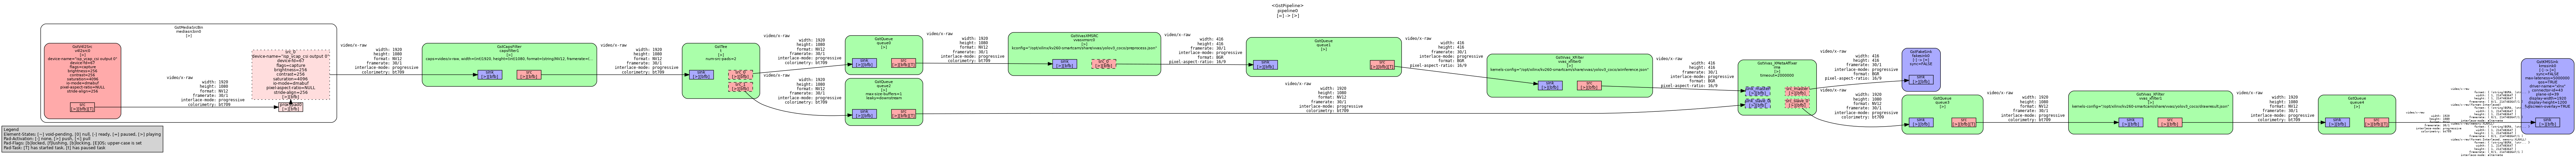

Pipeline graph is shown, double click it to zoom in and out.


In [22]:
import pydot
from IPython.display import Image, display, clear_output
if DP_output:
    dotfile = dotdir + "/" + nb + ".dot"
    print("Converting dot to graph...")
    graph = pydot.graph_from_dot_file(dotfile, 'utf-8')
    display(Image(graph[0].create(None,'png', 'utf-8')))
    print("Pipeline graph is shown, double click it to zoom in and out.")   

* Mainloop to be interruptable by clicking the stop square button on the Jupyter toolbar.

  **Notice:** For DP output case, stopping the process with the square button can only work until the previous step finishes to show the pipeline dot graph.

In [ ]:
if DP_output:
    loop = GLib.MainLoop()
    try:
        loop.run()
    except:
        sys.stdout.write("Interrupt caught\n")
        Gst.debug_bin_to_dot_file(pipe, Gst.DebugGraphDetails.ALL, nb)
        pipe.set_state(Gst.State.NULL)
        loop.quit()
        pass

## RTSP output

* Start an RTSP server will consume the GStreamer pipeline constructed in next section.

In [ ]:
if not DP_output:
    mainloop = GLib.MainLoop()
    server = GstRtspServer.RTSPServer.new()
    server.props.service = "5000"
    mounts = server.get_mount_points()
    serverid=server.attach(None)
    factory = GstRtspServer.RTSPMediaFactory()

### Then pass the frame with bbox to do VCU encoding with bbox info as encoding ROI.

* ROI info for VCU encoding generation


In [ ]:
if not DP_output:
    pip += ' ! queue ! vvas_xroigen roi-type=1 roi-qp-delta=-10 roi-max-num=10   '

* VCU encoding

In [ ]:
if not DP_output:
    pip += '! queue ! omxh264enc qp-mode=1 num-slices=8 gop-length=60 \
 periodicity-idr=270 control-rate=low-latency \
 gop-mode=low-delay-p gdr-mode=horizontal cpb-size=200 \
 initial-delay=100  filler-data=false min-qp=15 \
 max-qp=40  b-frames=0  low-bandwidth=false  target-bitrate=3000 \
! video/x-h264, alignment=au '

* RTP payloading

In [ ]:
if not DP_output:
    pip += '! queue ! rtph264pay name=pay0 pt=96'

* Start the RTSP Server With the Pipeline String

In [ ]:
if not DP_output:
    factory.set_launch('( ' + pip + ' )')
    factory.set_shared(True)
    mounts.add_factory("/test", factory)

    out=subprocess.check_output("ifconfig | grep inet", shell=True)
    for line in out.decode("ascii").splitlines():
        m = re.search('inet *(.*?) ', line)
        if m:
            found = m.group(1)
            if found != "127.0.0.1":
                break
    uri="rtsp://{}:{}/test".format("127.0.0.1" if (found=="") else found, server.props.service)
    print ("Video is now streaming from {src} source. \n\
    Run the command \"ffplay {uri}\" in another PC which have network access to the SoM board to view the video.\n".format(src=source, uri=uri))
    try:
        mainloop.run()
    except:
        sys.stdout.write("Interrupt caught.\n")
        GLib.Source.remove(serverid)
        mainloop.quit()
        pass


# 5. Summary
The Jupyter application shows how to:

1. Create a GStreamer pipeline which utilize the VVAS framework to call Vitis AI Library to do face detection inference on the incoming frames, and draw boundboxing of detected results.
2. Use the GStreamer RTSPServer module to setup an RTSP server.
3. User can try to customize the source to video file or USB camera.

<center>Copyright© 2021 Xilinx</center>